In [8]:
# !pip install nb-black
!pip install -q mne

/usr/bin/sh: 1: sudo: not found


In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [6]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[1],
)

In [7]:
for i in tqdm(range(len(ds))):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

  0%|          | 0/576 [00:00<?, ?it/s]

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [8]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [9]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Get CSP Weights

In [10]:
from cspnn.csp import CSP as CSP_base

In [11]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

csp = CSP_base(list(range(1, 5)), num_bands=1, num_windows=1)

In [12]:
signale = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signale.append(sig)
    label.append(lbl["label"])
signale = torch.vstack(signale)
label = torch.stack(label)

  0%|          | 0/288 [00:00<?, ?it/s]

In [13]:
signale.size(), label.size()

(torch.Size([288, 22, 1, 1, 1001]), torch.Size([288]))

In [14]:
weights = csp.calculate_weights(
    signals=signale.cpu().detach().numpy(), labels=label.cpu().detach().numpy()
)

In [16]:
weights.keys()

dict_keys(['label-1_band-0_window-0', 'label-2_band-0_window-0', 'label-3_band-0_window-0', 'label-4_band-0_window-0'])

## Model

In [17]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [18]:
import torch.optim as optim

In [19]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [20]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        # CLS CNN
        conv2d_batch_out_channels_1 = 40

        self.conv2d_1 = nn.Conv2d(
            in_channels=1,
            out_channels=conv2d_batch_out_channels_1,
            kernel_size=(1, 1),
            padding="same",
            stride=1,
        )

        self.batch_norm_1 = nn.BatchNorm2d(num_features=conv2d_batch_out_channels_1)

        self.activation = nn.ReLU()

        conv2d_batch_out_channels_2 = 40

        self.conv2d_2 = nn.Conv2d(
            in_channels=1,
            out_channels=conv2d_batch_out_channels_2,
            kernel_size=(1, 1),
            padding="same",
            stride=1,
        )

        self.batch_norm_2 = nn.BatchNorm2d(num_features=conv2d_batch_out_channels_2)

        self.flatten = nn.Flatten()

        drop_out_1 = 0.3
        self.drop_out_1 = nn.Dropout(p=drop_out_1)

        self.fc1 = nn.Linear(3520, 40)

        drop_out_2 = 0.2
        self.drop_out_2 = nn.Dropout(p=drop_out_2)

        self.fc2 = nn.Linear(40, 10)

        self.fc = nn.Linear(10, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        features = features.unsqueeze_(1)
        features = features.unsqueeze_(-1)

        # Cls CNN
        x = self.conv2d_1(features)
        x = self.batch_norm_1(x)
        x = self.activation(x)

        x = self.conv2d_2(features)
        x = self.batch_norm_2(x)
        x = self.activation(x)

        x = self.flatten(x)

        # print(f"{x.size() = }")

        x = self.drop_out_1(x)
        x = self.fc1(x)
        x = self.activation(x)

        x = self.drop_out_2(x)
        x = self.fc2(x)
        x = self.activation(x)

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [21]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [22]:
net.conv1.load_csp_weights(weights=weights, csp_template=csp.template)

## Train Loop

In [23]:
net = net.cuda()

In [24]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


9it [00:00, 11.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.387079808447096


Train -  [0.25, 0.0, 0.6889789094650206, 0.25, tensor(1.3861)]
Validation -  [0.25, 0.0, 0.6611689814814814, 0.25, tensor(1.3862)]

Epoch  1


9it [00:00, 15.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.381786823272705


Train -  [0.3125, 0.08333333333333337, 0.7394708076131687, 0.3125, tensor(1.3803)]
Validation -  [0.3402777777777778, 0.12037037037037035, 0.7302436985596708, 0.3402777777777778, tensor(1.3804)]

Epoch  2


9it [00:00, 19.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.370641337500678


Train -  [0.4131944444444444, 0.21759259259259256, 0.7860886059670782, 0.4131944444444444, tensor(1.3689)]
Validation -  [0.4027777777777778, 0.20370370370370372, 0.7595003858024691, 0.4027777777777778, tensor(1.3705)]

Epoch  3


9it [00:00, 15.51it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3616427977879841


Train -  [0.4027777777777778, 0.20370370370370372, 0.7925025720164609, 0.4027777777777778, tensor(1.3557)]
Validation -  [0.3958333333333333, 0.19444444444444442, 0.778469007201646, 0.3958333333333333, tensor(1.3575)]

Epoch  4


9it [00:00, 15.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.345682250128852


Train -  [0.5208333333333334, 0.36111111111111116, 0.7947530864197532, 0.5208333333333334, tensor(1.3470)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.761815200617284, 0.4479166666666667, tensor(1.3519)]

Epoch  5


9it [00:00, 21.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3333539300494723


Train -  [0.3298611111111111, 0.10648148148148151, 0.8294592335390947, 0.3298611111111111, tensor(1.3238)]
Validation -  [0.2847222222222222, 0.04629629629629628, 0.7844489454732511, 0.2847222222222222, tensor(1.3339)]

Epoch  6


9it [00:00, 20.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3254690435197618


Train -  [0.3125, 0.08333333333333337, 0.8180459104938271, 0.3125, tensor(1.3108)]
Validation -  [0.28125, 0.04166666666666663, 0.7495820473251029, 0.28125, tensor(1.3270)]

Epoch  7


9it [00:00, 19.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3147512806786432


Train -  [0.4444444444444444, 0.2592592592592593, 0.8103941615226338, 0.4444444444444444, tensor(1.3102)]
Validation -  [0.4270833333333333, 0.23611111111111116, 0.7509002057613168, 0.4270833333333333, tensor(1.3267)]

Epoch  8


9it [00:00, 31.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3103829887178209


Train -  [0.46875, 0.29166666666666663, 0.8246688528806585, 0.46875, tensor(1.3017)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.7543724279835391, 0.4340277777777778, tensor(1.3206)]

Epoch  9


9it [00:00, 19.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3050317764282227


Train -  [0.4027777777777778, 0.20370370370370372, 0.8230291923868314, 0.4027777777777778, tensor(1.2909)]
Validation -  [0.3298611111111111, 0.10648148148148151, 0.7448238168724279, 0.3298611111111111, tensor(1.3133)]

Epoch  10


9it [00:00, 19.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2867441574732463


Train -  [0.3506944444444444, 0.1342592592592593, 0.808641975308642, 0.3506944444444444, tensor(1.2774)]
Validation -  [0.3472222222222222, 0.12962962962962965, 0.7381204989711935, 0.3472222222222222, tensor(1.3075)]

Epoch  11


9it [00:00, 17.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.279452257686191


Train -  [0.5104166666666666, 0.3472222222222222, 0.8084812242798354, 0.5104166666666666, tensor(1.2538)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.7398244598765431, 0.4201388888888889, tensor(1.2921)]

Epoch  12


9it [00:00, 30.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.262671086523268


Train -  [0.5034722222222222, 0.3379629629629629, 0.8169528034979423, 0.5034722222222222, tensor(1.2358)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.755883487654321, 0.4201388888888889, tensor(1.2734)]

Epoch  13


9it [00:00, 16.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2625143395529852


Train -  [0.4965277777777778, 0.3287037037037037, 0.8152649176954733, 0.4965277777777778, tensor(1.2269)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.7470261059670782, 0.4305555555555556, tensor(1.2721)]

Epoch  14


9it [00:00, 18.02it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2548392348819308


Train -  [0.5, 0.33333333333333337, 0.82544045781893, 0.5, tensor(1.2250)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.7582786779835391, 0.4340277777777778, tensor(1.2678)]

Epoch  15


9it [00:00, 19.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.241376241048177


Train -  [0.5104166666666666, 0.3472222222222222, 0.8259387860082305, 0.5104166666666666, tensor(1.2181)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.7600147890946501, 0.4305555555555556, tensor(1.2665)]

Epoch  16


9it [00:00, 17.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2345551782184176


Train -  [0.5173611111111112, 0.3564814814814815, 0.8308899176954733, 0.5173611111111112, tensor(1.2125)]
Validation -  [0.4340277777777778, 0.24537037037037035, 0.7631012088477366, 0.4340277777777778, tensor(1.2633)]

Epoch  17


9it [00:00, 21.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2194992303848267


Train -  [0.5381944444444444, 0.3842592592592593, 0.8313560956790123, 0.5381944444444444, tensor(1.2052)]
Validation -  [0.4375, 0.25, 0.7605131172839505, 0.4375, tensor(1.2597)]

Epoch  18


9it [00:00, 16.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.225245131386651


Train -  [0.5486111111111112, 0.39814814814814814, 0.8354552469135803, 0.5486111111111112, tensor(1.2002)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7654481738683128, 0.4409722222222222, tensor(1.2569)]

Epoch  19


9it [00:00, 23.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.223771744304233


Train -  [0.5347222222222222, 0.37962962962962965, 0.8388953189300412, 0.5347222222222222, tensor(1.2002)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7733249742798354, 0.4409722222222222, tensor(1.2591)]

Epoch  20


9it [00:00, 17.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2113624281353421


Train -  [0.5104166666666666, 0.3472222222222222, 0.827465920781893, 0.5104166666666666, tensor(1.2017)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.765303497942387, 0.4652777777777778, tensor(1.2493)]

Epoch  21


9it [00:00, 20.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2264259258906047


Train -  [0.53125, 0.375, 0.8398759002057614, 0.53125, tensor(1.1917)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.7739197530864198, 0.4409722222222222, tensor(1.2546)]

Epoch  22


9it [00:00, 17.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.211756944656372


Train -  [0.5208333333333334, 0.36111111111111116, 0.838011188271605, 0.5208333333333334, tensor(1.1885)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7739679783950617, 0.4722222222222222, tensor(1.2439)]

Epoch  23


9it [00:00, 21.91it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2147447400622897
Train -  [0.5555555555555556, 0.40740740740740744, 0.8429462448559671, 0.5555555555555556, tensor(1.1884)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.7784368569958848, 0.4618055555555556, tensor(1.2495)]

Epoch  24


9it [00:00, 18.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2037006086773343


Train -  [0.5729166666666666, 0.4305555555555556, 0.8485243055555556, 0.5729166666666666, tensor(1.1811)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7854777520576133, 0.4756944444444444, tensor(1.2378)]

Epoch  25


9it [00:00, 21.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1865803003311157


Train -  [0.5798611111111112, 0.43981481481481477, 0.8488136574074073, 0.5798611111111112, tensor(1.1791)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7827128343621399, 0.4756944444444444, tensor(1.2422)]

Epoch  26


9it [00:00, 19.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.202164398299323


Train -  [0.5868055555555556, 0.44907407407407407, 0.8513695987654321, 0.5868055555555556, tensor(1.1739)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.7870531121399178, 0.4722222222222222, tensor(1.2392)]

Epoch  27


9it [00:00, 19.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2113614347245958


Train -  [0.5763888888888888, 0.43518518518518523, 0.8495531121399177, 0.5763888888888888, tensor(1.1748)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.780446244855967, 0.4791666666666667, tensor(1.2348)]

Epoch  28


9it [00:00, 22.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1829092767503526


Train -  [0.5659722222222222, 0.4212962962962963, 0.8572530864197531, 0.5659722222222222, tensor(1.1685)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.787085262345679, 0.4652777777777778, tensor(1.2322)]

Epoch  29


9it [00:00, 17.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.196928275956048


Train -  [0.5868055555555556, 0.44907407407407407, 0.852076903292181, 0.5868055555555556, tensor(1.1690)]
Validation -  [0.46875, 0.29166666666666663, 0.7854134516460904, 0.46875, tensor(1.2355)]

Epoch  30


9it [00:00, 21.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1925215986039903


Train -  [0.5833333333333334, 0.4444444444444444, 0.8524787808641976, 0.5833333333333334, tensor(1.1642)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7826163837448559, 0.4895833333333333, tensor(1.2321)]

Epoch  31


9it [00:00, 21.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1960584322611492


Train -  [0.6284722222222222, 0.5046296296296297, 0.86328125, 0.6284722222222222, tensor(1.1589)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.7933384773662552, 0.4930555555555556, tensor(1.2278)]

Epoch  32


9it [00:00, 18.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.190621746910943


Train -  [0.5590277777777778, 0.4120370370370371, 0.8682806069958848, 0.5590277777777778, tensor(1.1617)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.7940618569958848, 0.4791666666666667, tensor(1.2291)]

Epoch  33


9it [00:00, 19.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2157407071855333


Train -  [0.5555555555555556, 0.40740740740740744, 0.8540380658436215, 0.5555555555555556, tensor(1.1792)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7826485339506173, 0.4895833333333333, tensor(1.2332)]

Epoch  34


9it [00:00, 19.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.208132849799262


Train -  [0.5451388888888888, 0.3935185185185185, 0.8544399434156379, 0.5451388888888888, tensor(1.1764)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.7914576903292181, 0.4652777777777778, tensor(1.2374)]

Epoch  35


9it [00:00, 14.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1801290379630194


Train -  [0.5625, 0.41666666666666663, 0.8570280349794239, 0.5625, tensor(1.1707)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.7869405864197532, 0.4756944444444444, tensor(1.2299)]

Epoch  36


9it [00:00, 17.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1805953449673123


Train -  [0.5972222222222222, 0.4629629629629629, 0.8592463991769548, 0.5972222222222222, tensor(1.1612)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7942547582304527, 0.4895833333333333, tensor(1.2269)]

Epoch  37


9it [00:00, 27.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.185297105047438


Train -  [0.6076388888888888, 0.47685185185185186, 0.8676697530864197, 0.6076388888888888, tensor(1.1525)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7974376286008231, 0.5138888888888888, tensor(1.2201)]

Epoch  38


9it [00:00, 17.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1807352304458618


Train -  [0.6076388888888888, 0.47685185185185186, 0.8701774691358026, 0.6076388888888888, tensor(1.1505)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.8022923096707819, 0.4930555555555556, tensor(1.2210)]

Epoch  39


9it [00:00, 18.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1854905022515192


Train -  [0.625, 0.5, 0.8691486625514403, 0.625, tensor(1.1555)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7985789609053499, 0.5138888888888888, tensor(1.2205)]

Epoch  40


9it [00:00, 31.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1791493230395846


Train -  [0.6041666666666666, 0.4722222222222222, 0.8761895576131687, 0.6041666666666666, tensor(1.1613)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.8101208847736625, 0.4895833333333333, tensor(1.2262)]

Epoch  41


9it [00:00, 28.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1704790194829304


Train -  [0.6215277777777778, 0.49537037037037035, 0.8633134002057613, 0.6215277777777778, tensor(1.1536)]
Validation -  [0.5, 0.33333333333333337, 0.7917791923868314, 0.5, tensor(1.2226)]

Epoch  42


9it [00:00, 22.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1690261099073622


Train -  [0.5972222222222222, 0.4629629629629629, 0.8781989454732511, 0.5972222222222222, tensor(1.1528)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.8107799639917694, 0.4791666666666667, tensor(1.2227)]

Epoch  43


9it [00:00, 15.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1789344019360013


Train -  [0.6493055555555556, 0.5324074074074074, 0.8771058384773662, 0.6493055555555556, tensor(1.1379)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.8031764403292181, 0.4826388888888889, tensor(1.2171)]

Epoch  44


9it [00:00, 17.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1723874409993489


Train -  [0.6284722222222222, 0.5046296296296297, 0.877025462962963, 0.6284722222222222, tensor(1.1364)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.7982574588477367, 0.5104166666666666, tensor(1.2124)]

Epoch  45


9it [00:00, 18.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1517197158601549


Train -  [0.6041666666666666, 0.4722222222222222, 0.8615612139917694, 0.6041666666666666, tensor(1.1530)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.7908629115226338, 0.4861111111111111, tensor(1.2316)]

Epoch  46


9it [00:00, 20.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.168102913432651


Train -  [0.6041666666666666, 0.4722222222222222, 0.8741801697530864, 0.6041666666666666, tensor(1.1439)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.7991415895061729, 0.4895833333333333, tensor(1.2173)]

Epoch  47


9it [00:00, 27.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1682203478283353


Train -  [0.6145833333333334, 0.48611111111111116, 0.8719778806584363, 0.6145833333333334, tensor(1.1372)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.7930491255144033, 0.5173611111111112, tensor(1.2151)]

Epoch  48


9it [00:00, 22.33it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1481377283732097
Train -  [0.6215277777777778, 0.49537037037037035, 0.8695987654320987, 0.6215277777777778, tensor(1.1361)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.7958301183127572, 0.5138888888888888, tensor(1.2165)]

Epoch  49


9it [00:00, 24.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1726336611641779


Train -  [0.6736111111111112, 0.5648148148148149, 0.8874099794238683, 0.6736111111111112, tensor(1.1166)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.8061181841563786, 0.5138888888888888, tensor(1.2052)]

Epoch  50


9it [00:00, 14.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.153646641307407


Train -  [0.6493055555555556, 0.5324074074074074, 0.8887924382716048, 0.6493055555555556, tensor(1.1226)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8099440586419753, 0.5104166666666666, tensor(1.2112)]

Epoch  51


9it [00:00, 20.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1361648771497939


Train -  [0.6493055555555556, 0.5324074074074074, 0.8863168724279835, 0.6493055555555556, tensor(1.1145)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.807468492798354, 0.5034722222222222, tensor(1.2042)]

Epoch  52


9it [00:00, 32.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1317559878031414


Train -  [0.6597222222222222, 0.5462962962962963, 0.8842753343621399, 0.6597222222222222, tensor(1.1174)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.8050411522633745, 0.5069444444444444, tensor(1.2112)]

Epoch  53


9it [00:00, 18.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1476117504967585


Train -  [0.6909722222222222, 0.587962962962963, 0.8931809413580247, 0.6909722222222222, tensor(1.1085)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8132233796296298, 0.5104166666666666, tensor(1.2048)]

Epoch  54


9it [00:00, 17.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1238427228397794


Train -  [0.6666666666666666, 0.5555555555555556, 0.8922807355967077, 0.6666666666666666, tensor(1.1016)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.8123553240740741, 0.5208333333333334, tensor(1.1992)]

Epoch  55


9it [00:00, 29.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1262160672081842


Train -  [0.6840277777777778, 0.5787037037037037, 0.889499742798354, 0.6840277777777778, tensor(1.1013)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.806053883744856, 0.5347222222222222, tensor(1.1964)]

Epoch  56


9it [00:00, 25.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1676442093319364


Train -  [0.6736111111111112, 0.5648148148148149, 0.8940007716049383, 0.6736111111111112, tensor(1.1016)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.8136895576131686, 0.5208333333333334, tensor(1.2015)]

Epoch  57


9it [00:00, 18.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.167005631658766


Train -  [0.6006944444444444, 0.46759259259259256, 0.8781346450617284, 0.6006944444444444, tensor(1.1336)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.7964731224279836, 0.5277777777777778, tensor(1.2103)]

Epoch  58


9it [00:00, 27.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1502507130304973


Train -  [0.6319444444444444, 0.5092592592592593, 0.8843074845679012, 0.6319444444444444, tensor(1.1141)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8139306841563786, 0.5173611111111112, tensor(1.2030)]

Epoch  59


9it [00:00, 17.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1291691462198894


Train -  [0.6805555555555556, 0.5740740740740741, 0.8952546296296297, 0.6805555555555556, tensor(1.0896)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8117605452674896, 0.5243055555555556, tensor(1.1992)]

Epoch  60


9it [00:00, 26.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1388390991422865


Train -  [0.6805555555555556, 0.5740740740740741, 0.8988393775720164, 0.6805555555555556, tensor(1.0925)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8221289866255144, 0.5277777777777778, tensor(1.1969)]

Epoch  61


9it [00:00, 28.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1172643502553303


Train -  [0.6840277777777778, 0.5787037037037037, 0.8991126543209876, 0.6840277777777778, tensor(1.0818)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.8162615740740741, 0.5555555555555556, tensor(1.1885)]

Epoch  62


9it [00:00, 19.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1392461591296725


Train -  [0.6840277777777778, 0.5787037037037037, 0.8986947016460907, 0.6840277777777778, tensor(1.0821)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.8150720164609053, 0.5381944444444444, tensor(1.1892)]

Epoch  63


9it [00:00, 22.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.117968413564894


Train -  [0.6631944444444444, 0.5509259259259259, 0.8855774176954733, 0.6631944444444444, tensor(1.1027)]
Validation -  [0.5, 0.33333333333333337, 0.798900462962963, 0.5, tensor(1.2054)]

Epoch  64


9it [00:00, 22.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1256933609644573


Train -  [0.6909722222222222, 0.587962962962963, 0.8993859310699589, 0.6909722222222222, tensor(1.0829)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.8183995627572016, 0.5173611111111112, tensor(1.1947)]

Epoch  65


9it [00:00, 16.74it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1432976325352986


Train -  [0.6319444444444444, 0.5092592592592593, 0.892698688271605, 0.6319444444444444, tensor(1.1126)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.808497299382716, 0.5381944444444444, tensor(1.2059)]

Epoch  66


9it [00:00, 18.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1338873969184027


Train -  [0.6736111111111112, 0.5648148148148149, 0.8971032664609053, 0.6736111111111112, tensor(1.0745)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8155864197530865, 0.5486111111111112, tensor(1.1850)]

Epoch  67


9it [00:00, 22.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1001453267203436


Train -  [0.6979166666666666, 0.5972222222222222, 0.903517232510288, 0.6979166666666666, tensor(1.0702)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.8175475823045267, 0.5555555555555556, tensor(1.1854)]

Epoch  68


9it [00:00, 18.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.099818574057685


Train -  [0.6736111111111112, 0.5648148148148149, 0.905735596707819, 0.6736111111111112, tensor(1.0834)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8177244084362141, 0.5486111111111112, tensor(1.1844)]

Epoch  69


9it [00:00, 17.96it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.104088094499376


Train -  [0.7013888888888888, 0.6018518518518519, 0.9057998971193415, 0.7013888888888888, tensor(1.0631)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8183674125514404, 0.5486111111111112, tensor(1.1815)]

Epoch  70


9it [00:00, 18.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.104169872072008


Train -  [0.6875, 0.5833333333333333, 0.905687371399177, 0.6875, tensor(1.0680)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.81909079218107, 0.5555555555555556, tensor(1.1784)]

Epoch  71


9it [00:00, 17.92it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1037026445070903


Train -  [0.6909722222222222, 0.587962962962963, 0.9036940586419754, 0.6909722222222222, tensor(1.0656)]
Validation -  [0.53125, 0.375, 0.8158275462962963, 0.53125, tensor(1.1909)]

Epoch  72


9it [00:00, 20.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0923126935958862


Train -  [0.65625, 0.5416666666666667, 0.9002218364197531, 0.65625, tensor(1.0795)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8219039351851851, 0.5486111111111112, tensor(1.1813)]

Epoch  73


9it [00:00, 17.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1145375967025757


Train -  [0.6701388888888888, 0.5601851851851851, 0.9035976080246915, 0.6701388888888888, tensor(1.0742)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8166956018518519, 0.5243055555555556, tensor(1.1965)]

Epoch  74


9it [00:00, 16.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.115489708052741


Train -  [0.6736111111111112, 0.5648148148148149, 0.9031153549382716, 0.6736111111111112, tensor(1.0821)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.8212770061728396, 0.5416666666666666, tensor(1.1814)]

Epoch  75


9it [00:00, 15.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1008914046817355


Train -  [0.6979166666666666, 0.5972222222222222, 0.9095293209876543, 0.6979166666666666, tensor(1.0545)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8222254372427984, 0.5486111111111112, tensor(1.1841)]

Epoch  76


9it [00:00, 20.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0918557114071317


Train -  [0.7048611111111112, 0.6064814814814814, 0.9057516718106995, 0.7048611111111112, tensor(1.0580)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8293306327160493, 0.5243055555555556, tensor(1.1801)]

Epoch  77


9it [00:00, 17.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1159668895933363


Train -  [0.71875, 0.625, 0.9083397633744856, 0.71875, tensor(1.0577)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.8283822016460904, 0.5451388888888888, tensor(1.1854)]

Epoch  78


9it [00:00, 16.39it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0837974548339844
Train -  [0.65625, 0.5416666666666667, 0.9020222479423868, 0.65625, tensor(1.0833)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.8087384259259258, 0.5104166666666666, tensor(1.1924)]

Epoch  79


9it [00:00, 21.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1151281860139635


Train -  [0.7048611111111112, 0.6064814814814814, 0.906153549382716, 0.7048611111111112, tensor(1.0591)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.8261156121399176, 0.5520833333333334, tensor(1.1802)]

Epoch  80


9it [00:00, 20.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.095547080039978


Train -  [0.6909722222222222, 0.587962962962963, 0.909400720164609, 0.6909722222222222, tensor(1.0675)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8247974537037037, 0.5590277777777778, tensor(1.1774)]

Epoch  81


9it [00:00, 19.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1068122784296672


Train -  [0.7013888888888888, 0.6018518518518519, 0.9057998971193415, 0.7013888888888888, tensor(1.0506)]
Validation -  [0.5625, 0.41666666666666663, 0.8147183641975309, 0.5625, tensor(1.1837)]

Epoch  82


9it [00:00, 15.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0991721815533109


Train -  [0.6875, 0.5833333333333333, 0.904272762345679, 0.6875, tensor(1.0623)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.8325135030864198, 0.5416666666666666, tensor(1.1740)]

Epoch  83


9it [00:00, 26.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.101126538382636


Train -  [0.7118055555555556, 0.6157407407407407, 0.9111207561728395, 0.7118055555555557, tensor(1.0422)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.830054012345679, 0.5416666666666666, tensor(1.1729)]

Epoch  84


9it [00:00, 17.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0885710914929707


Train -  [0.7048611111111112, 0.6064814814814814, 0.9130015432098766, 0.7048611111111112, tensor(1.0472)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.8295717592592593, 0.5381944444444444, tensor(1.1729)]

Epoch  85


9it [00:00, 21.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0696991682052612


Train -  [0.7118055555555556, 0.6157407407407407, 0.9098186728395061, 0.7118055555555557, tensor(1.0429)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.8290412808641976, 0.5520833333333334, tensor(1.1684)]

Epoch  86


9it [00:00, 29.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0836998489167955


Train -  [0.7152777777777778, 0.6203703703703703, 0.9084683641975309, 0.7152777777777778, tensor(1.0493)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.8285268775720165, 0.5520833333333334, tensor(1.1803)]

Epoch  87


9it [00:00, 15.33it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0937310258547466


Train -  [0.7083333333333334, 0.6111111111111112, 0.91137795781893, 0.7083333333333334, tensor(1.0384)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8221289866255144, 0.5486111111111112, tensor(1.1743)]

Epoch  88


9it [00:00, 17.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0791488620969985


Train -  [0.7083333333333334, 0.6111111111111112, 0.9088541666666666, 0.7083333333333334, tensor(1.0477)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8348926183127572, 0.5486111111111112, tensor(1.1704)]

Epoch  89


9it [00:00, 22.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0942659311824374


Train -  [0.7256944444444444, 0.6342592592592593, 0.9115065586419753, 0.7256944444444444, tensor(1.0402)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.8312757201646092, 0.5763888888888888, tensor(1.1652)]

Epoch  90


9it [00:00, 17.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0959120723936293


Train -  [0.7118055555555556, 0.6157407407407407, 0.9095614711934156, 0.7118055555555557, tensor(1.0378)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8301826131687243, 0.5902777777777778, tensor(1.1634)]

Epoch  91


9it [00:00, 18.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0748281346427069


Train -  [0.7326388888888888, 0.6435185185185186, 0.9152359825102881, 0.7326388888888888, tensor(1.0448)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8258905606995885, 0.5659722222222222, tensor(1.1719)]

Epoch  92


9it [00:00, 20.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0812998877631292


Train -  [0.6631944444444444, 0.5509259259259259, 0.9094489454732511, 0.6631944444444444, tensor(1.0665)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.8362429269547326, 0.5381944444444444, tensor(1.1866)]

Epoch  93


9it [00:00, 19.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1081349849700928


Train -  [0.7013888888888888, 0.6018518518518519, 0.9146894290123457, 0.7013888888888888, tensor(1.0628)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8260513117283951, 0.5659722222222222, tensor(1.1775)]

Epoch  94


9it [00:00, 25.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0952244533432856


Train -  [0.7048611111111112, 0.6064814814814814, 0.9121013374485596, 0.7048611111111112, tensor(1.0498)]
Validation -  [0.5625, 0.41666666666666663, 0.8239293981481481, 0.5625, tensor(1.1808)]

Epoch  95


9it [00:00, 17.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.069743898179796


Train -  [0.7222222222222222, 0.6296296296296297, 0.9140946502057612, 0.7222222222222222, tensor(1.0409)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8224987139917695, 0.5729166666666666, tensor(1.1710)]

Epoch  96


9it [00:00, 17.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0884693728552923


Train -  [0.7118055555555556, 0.6157407407407407, 0.9162326388888888, 0.7118055555555557, tensor(1.0327)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8273373199588476, 0.5659722222222222, tensor(1.1701)]

Epoch  97


9it [00:00, 20.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0758126378059387


Train -  [0.7013888888888888, 0.6018518518518519, 0.9088059413580247, 0.7013888888888888, tensor(1.0675)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.8141235853909465, 0.5763888888888888, tensor(1.1894)]

Epoch  98


9it [00:00, 19.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1131588684187994


Train -  [0.7222222222222222, 0.6296296296296297, 0.9096257716049383, 0.7222222222222222, tensor(1.0364)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8332368827160495, 0.5729166666666666, tensor(1.1644)]

Epoch  99


9it [00:00, 21.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0945261120796204


Train -  [0.7013888888888888, 0.6018518518518519, 0.9115869341563786, 0.7013888888888888, tensor(1.0407)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.8224504886831276, 0.5416666666666666, tensor(1.1755)]

Epoch  100


9it [00:00, 18.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.050228966606988


Train -  [0.7256944444444444, 0.6342592592592593, 0.9153485082304528, 0.7256944444444444, tensor(1.0313)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.8284786522633746, 0.5555555555555556, tensor(1.1662)]

Epoch  101


9it [00:00, 16.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.078415036201477


Train -  [0.7118055555555556, 0.6157407407407407, 0.9153485082304527, 0.7118055555555557, tensor(1.0282)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8265014146090535, 0.5659722222222222, tensor(1.1662)]

Epoch  102


9it [00:00, 20.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0635321272744074


Train -  [0.7361111111111112, 0.6481481481481481, 0.9152520576131686, 0.7361111111111113, tensor(1.0303)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8273855452674899, 0.5694444444444444, tensor(1.1659)]

Epoch  103


9it [00:00, 16.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.081449270248413


Train -  [0.7118055555555556, 0.6157407407407407, 0.9138374485596708, 0.7118055555555557, tensor(1.0451)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8340727880658436, 0.5590277777777778, tensor(1.1699)]

Epoch  104


9it [00:00, 21.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0957216686672635


Train -  [0.7430555555555556, 0.6574074074074074, 0.9179526748971194, 0.7430555555555556, tensor(1.0345)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8271122685185186, 0.5659722222222222, tensor(1.1689)]

Epoch  105


9it [00:00, 21.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0458075867758856


Train -  [0.75, 0.6666666666666667, 0.9176954732510288, 0.75, tensor(1.0249)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.830857767489712, 0.5694444444444444, tensor(1.1622)]

Epoch  106


9it [00:00, 17.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0587621927261353


Train -  [0.7361111111111112, 0.6481481481481481, 0.9163933899176955, 0.7361111111111113, tensor(1.0216)]
Validation -  [0.5625, 0.41666666666666663, 0.8341210133744856, 0.5625, tensor(1.1574)]

Epoch  107


9it [00:00, 19.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0645355449782476


Train -  [0.71875, 0.625, 0.9175025720164609, 0.71875, tensor(1.0239)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8346273791152263, 0.5729166666666666, tensor(1.1600)]

Epoch  108


9it [00:00, 21.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0736662613021002


Train -  [0.7291666666666666, 0.6388888888888888, 0.9185956790123456, 0.7291666666666665, tensor(1.0193)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8288001543209877, 0.5798611111111112, tensor(1.1648)]

Epoch  109


9it [00:00, 22.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0587387614780002


Train -  [0.7534722222222222, 0.6712962962962963, 0.918724279835391, 0.7534722222222221, tensor(1.0178)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8318383487654322, 0.5868055555555556, tensor(1.1616)]

Epoch  110


9it [00:00, 18.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0744302140341864


Train -  [0.71875, 0.625, 0.917164994855967, 0.71875, tensor(1.0269)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8443769290123457, 0.5659722222222222, tensor(1.1571)]

Epoch  111


9it [00:00, 21.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0642022093137105


Train -  [0.7604166666666666, 0.6805555555555556, 0.9177758487654321, 0.7604166666666666, tensor(1.0290)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.8215181327160493, 0.5486111111111112, tensor(1.1813)]

Epoch  112


9it [00:00, 18.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0753421319855585


Train -  [0.7222222222222222, 0.6296296296296297, 0.91796875, 0.7222222222222222, tensor(1.0199)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8395383230452675, 0.5659722222222222, tensor(1.1544)]

Epoch  113


9it [00:00, 18.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.06250180138482


Train -  [0.7465277777777778, 0.662037037037037, 0.921312371399177, 0.7465277777777777, tensor(1.0097)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8355838477366255, 0.5729166666666666, tensor(1.1573)]

Epoch  114


9it [00:00, 21.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0563124020894368


Train -  [0.75, 0.6666666666666667, 0.9193833590534979, 0.75, tensor(1.0046)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8291216563786008, 0.5798611111111112, tensor(1.1621)]

Epoch  115


9it [00:00, 16.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0465728375646803


Train -  [0.7256944444444444, 0.6342592592592593, 0.9170846193415637, 0.7256944444444444, tensor(1.0201)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8346514917695473, 0.5902777777777778, tensor(1.1546)]

Epoch  116


9it [00:00, 23.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.083798156844245


Train -  [0.71875, 0.625, 0.9153645833333333, 0.71875, tensor(1.0425)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8278677983539096, 0.5277777777777778, tensor(1.1771)]

Epoch  117


9it [00:00, 18.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0700016154183283


Train -  [0.7361111111111112, 0.6481481481481481, 0.9195601851851851, 0.7361111111111113, tensor(1.0170)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8412583590534979, 0.5902777777777778, tensor(1.1431)]

Epoch  118


9it [00:00, 22.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0816659993595548


Train -  [0.7326388888888888, 0.6435185185185186, 0.9208461934156379, 0.7326388888888888, tensor(1.0070)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8435570987654321, 0.5972222222222222, tensor(1.1446)]

Epoch  119


9it [00:00, 18.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0904261138704088


Train -  [0.7152777777777778, 0.6203703703703703, 0.9146412037037037, 0.7152777777777778, tensor(1.0323)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.8244277263374485, 0.5347222222222222, tensor(1.1784)]

Epoch  120


9it [00:00, 18.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0669396652115717


Train -  [0.7534722222222222, 0.6712962962962963, 0.9205568415637859, 0.7534722222222221, tensor(1.0268)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8444894547325102, 0.5694444444444444, tensor(1.1550)]

Epoch  121


9it [00:00, 18.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0932648513052199


Train -  [0.7222222222222222, 0.6296296296296297, 0.9211998456790124, 0.7222222222222222, tensor(1.0294)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8467078189300412, 0.5694444444444444, tensor(1.1574)]

Epoch  122


9it [00:00, 23.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0645901163419087


Train -  [0.7430555555555556, 0.6574074074074074, 0.9198656121399176, 0.7430555555555556, tensor(1.0025)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8375851980452675, 0.5659722222222222, tensor(1.1540)]

Epoch  123


9it [00:00, 15.63it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.041129642062717


Train -  [0.7430555555555556, 0.6574074074074074, 0.9215052726337448, 0.7430555555555556, tensor(1.0034)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8410976080246914, 0.5694444444444444, tensor(1.1517)]

Epoch  124


9it [00:00, 14.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.06540580590566


Train -  [0.75, 0.6666666666666667, 0.9269868827160495, 0.75, tensor(1.0159)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.8399241255144033, 0.5520833333333334, tensor(1.1658)]

Epoch  125


9it [00:00, 25.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0330897635883756


Train -  [0.7534722222222222, 0.6712962962962963, 0.9236914866255144, 0.7534722222222221, tensor(0.9971)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8411458333333334, 0.5729166666666666, tensor(1.1487)]

Epoch  126


9it [00:00, 18.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0715984370973375


Train -  [0.7083333333333334, 0.6111111111111112, 0.9154931841563787, 0.7083333333333334, tensor(1.0395)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8519322273662552, 0.5972222222222222, tensor(1.1295)]

Epoch  127


9it [00:00, 17.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0816723042064242


Train -  [0.7638888888888888, 0.6851851851851851, 0.9277745627572016, 0.763888888888889, tensor(1.0011)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.8349408436213991, 0.5763888888888888, tensor(1.1585)]

Epoch  128


9it [00:00, 23.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0479513141844008


Train -  [0.7430555555555556, 0.6574074074074074, 0.9264242541152263, 0.7430555555555556, tensor(0.9966)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8321920010288066, 0.5694444444444444, tensor(1.1587)]

Epoch  129


9it [00:00, 21.49it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0911336474948459


Train -  [0.7569444444444444, 0.6759259259259259, 0.9250417952674898, 0.7569444444444444, tensor(0.9981)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8414994855967077, 0.5729166666666666, tensor(1.1448)]

Epoch  130


9it [00:00, 17.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0385258793830872


Train -  [0.7534722222222222, 0.6712962962962963, 0.925025720164609, 0.7534722222222221, tensor(0.9957)]
Validation -  [0.59375, 0.45833333333333337, 0.8360178755144033, 0.59375, tensor(1.1510)]

Epoch  131


9it [00:00, 21.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0128102435006037


Train -  [0.7604166666666666, 0.6805555555555556, 0.9256365740740742, 0.7604166666666666, tensor(1.0003)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8427372685185185, 0.6006944444444444, tensor(1.1423)]

Epoch  132


9it [00:00, 26.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0551524957021077


Train -  [0.7395833333333334, 0.6527777777777778, 0.9228395061728395, 0.7395833333333334, tensor(1.0014)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8365644290123457, 0.5659722222222222, tensor(1.1495)]

Epoch  133


9it [00:00, 15.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1090319951375325


Train -  [0.7395833333333334, 0.6527777777777778, 0.9232092335390947, 0.7395833333333334, tensor(1.0072)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.8316374099794238, 0.5451388888888888, tensor(1.1678)]

Epoch  134


9it [00:00, 19.77it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0702559484375849


Train -  [0.7256944444444444, 0.6342592592592593, 0.9279996141975309, 0.7256944444444444, tensor(1.0042)]
Validation -  [0.59375, 0.45833333333333337, 0.8403581532921811, 0.59375, tensor(1.1482)]

Epoch  135


9it [00:00, 15.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.058354722128974


Train -  [0.7361111111111112, 0.6481481481481481, 0.9283532664609053, 0.7361111111111113, tensor(1.0114)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.844553755144033, 0.5729166666666666, tensor(1.1559)]

Epoch  136


9it [00:00, 20.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0817728175057306


Train -  [0.7673611111111112, 0.6898148148148149, 0.9302019032921811, 0.7673611111111112, tensor(1.0013)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8439107510288066, 0.5868055555555556, tensor(1.1530)]

Epoch  137


9it [00:00, 18.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0717895560794406


Train -  [0.7569444444444444, 0.6759259259259259, 0.9259741512345679, 0.7569444444444444, tensor(1.0006)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8387988683127572, 0.5868055555555556, tensor(1.1497)]

Epoch  138


9it [00:00, 16.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0706724988089666


Train -  [0.75, 0.6666666666666667, 0.9272601594650206, 0.75, tensor(1.0002)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8395865483539096, 0.5902777777777778, tensor(1.1517)]

Epoch  139


9it [00:00, 25.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0516882207658556


Train -  [0.7361111111111112, 0.6481481481481481, 0.930812757201646, 0.7361111111111113, tensor(1.0189)]
Validation -  [0.5625, 0.41666666666666663, 0.8395222479423867, 0.5625, tensor(1.1668)]

Epoch  140


9it [00:00, 18.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.057603206899431


Train -  [0.7604166666666666, 0.6805555555555556, 0.9264242541152263, 0.7604166666666666, tensor(0.9975)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8519000771604938, 0.5798611111111112, tensor(1.1440)]

Epoch  141


9it [00:00, 20.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0877535343170166


Train -  [0.7430555555555556, 0.6574074074074074, 0.926633230452675, 0.7430555555555556, tensor(1.0018)]
Validation -  [0.59375, 0.45833333333333337, 0.8446984310699588, 0.59375, tensor(1.1481)]

Epoch  142


9it [00:00, 16.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0477373997370403


Train -  [0.7291666666666666, 0.6388888888888888, 0.9221965020576132, 0.7291666666666665, tensor(1.0273)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.8298771862139918, 0.5347222222222222, tensor(1.1720)]

Epoch  143


9it [00:00, 19.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0649636718961928


Train -  [0.7777777777777778, 0.7037037037037037, 0.931005658436214, 0.7777777777777778, tensor(0.9932)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8480742026748972, 0.6006944444444444, tensor(1.1431)]

Epoch  144


9it [00:00, 17.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0629525648223028


Train -  [0.7847222222222222, 0.712962962962963, 0.9312307098765431, 0.7847222222222222, tensor(0.9899)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8448270318930041, 0.5798611111111112, tensor(1.1531)]

Epoch  145


9it [00:00, 23.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.02687982055876


Train -  [0.7569444444444444, 0.6759259259259259, 0.926392103909465, 0.7569444444444444, tensor(0.9971)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8446100180041153, 0.5798611111111112, tensor(1.1513)]

Epoch  146


9it [00:00, 24.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0397262308332655


Train -  [0.7638888888888888, 0.6851851851851851, 0.9264885545267489, 0.763888888888889, tensor(1.0011)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8255449459876543, 0.5590277777777778, tensor(1.1713)]

Epoch  147


9it [00:00, 18.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0263840556144714


Train -  [0.7534722222222222, 0.6712962962962963, 0.927195859053498, 0.7534722222222221, tensor(1.0036)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.8491994598765432, 0.5763888888888888, tensor(1.1500)]

Epoch  148


9it [00:00, 15.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0603415105077956


Train -  [0.7673611111111112, 0.6898148148148149, 0.928931970164609, 0.7673611111111112, tensor(0.9906)]
Validation -  [0.5625, 0.41666666666666663, 0.8272649819958848, 0.5625, tensor(1.1684)]

Epoch  149


9it [00:00, 19.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0420265396436055


Train -  [0.7673611111111112, 0.6898148148148149, 0.9317772633744856, 0.7673611111111112, tensor(0.9815)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8403903034979423, 0.5798611111111112, tensor(1.1489)]

Epoch  150


9it [00:00, 19.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0363842646280925


Train -  [0.7638888888888888, 0.6851851851851851, 0.9323077417695473, 0.763888888888889, tensor(0.9830)]
Validation -  [0.59375, 0.45833333333333337, 0.846530992798354, 0.59375, tensor(1.1447)]

Epoch  151


9it [00:00, 16.58it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0683358775244818
Train -  [0.7465277777777778, 0.662037037037037, 0.9266010802469136, 0.7465277777777777, tensor(1.0211)]
Validation -  [0.5694444444444444, 0.42592592592592593, 0.8277070473251029, 0.5694444444444444, tensor(1.1696)]

Epoch  152


9it [00:00, 16.58it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.054309970802731
Train -  [0.7465277777777778, 0.662037037037037, 0.9330632716049383, 0.7465277777777777, tensor(0.9874)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8469167952674896, 0.5902777777777778, tensor(1.1416)]

Epoch  153


9it [00:00, 27.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.051242258813646


Train -  [0.7569444444444444, 0.6759259259259259, 0.9282889660493827, 0.7569444444444444, tensor(1.0059)]
Validation -  [0.5625, 0.41666666666666663, 0.8293306327160495, 0.5625, tensor(1.1646)]

Epoch  154


9it [00:00, 16.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0906333261066012


Train -  [0.7569444444444444, 0.6759259259259259, 0.927854938271605, 0.7569444444444444, tensor(0.9934)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8411779835390947, 0.6111111111111112, tensor(1.1419)]

Epoch  155


9it [00:00, 21.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0600861112276714


Train -  [0.7361111111111112, 0.6481481481481481, 0.9240451388888888, 0.7361111111111113, tensor(1.0120)]
Validation -  [0.5277777777777778, 0.37037037037037035, 0.8260191615226338, 0.5277777777777778, tensor(1.1767)]

Epoch  156


9it [00:00, 16.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0329289370112948


Train -  [0.7569444444444444, 0.6759259259259259, 0.9351369598765432, 0.7569444444444444, tensor(0.9980)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8470614711934156, 0.5590277777777778, tensor(1.1580)]

Epoch  157


9it [00:00, 21.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0732232928276062


Train -  [0.7534722222222222, 0.6712962962962963, 0.9334490740740742, 0.7534722222222221, tensor(0.9865)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.850806970164609, 0.5729166666666666, tensor(1.1481)]

Epoch  158


9it [00:00, 23.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.045366923014323


Train -  [0.7569444444444444, 0.6759259259259259, 0.9308770576131686, 0.7569444444444444, tensor(0.9987)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8464506172839507, 0.6041666666666666, tensor(1.1395)]

Epoch  159


9it [00:00, 18.45it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0653748114903767


Train -  [0.7604166666666666, 0.6805555555555556, 0.929639274691358, 0.7604166666666666, tensor(1.0126)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.8339763374485596, 0.5555555555555556, tensor(1.1719)]

Epoch  160


9it [00:00, 20.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0457222991519504


Train -  [0.7708333333333334, 0.6944444444444444, 0.930812757201646, 0.7708333333333333, tensor(0.9925)]
Validation -  [0.5833333333333334, 0.4444444444444444, 0.8366126543209876, 0.5833333333333334, tensor(1.1518)]

Epoch  161


9it [00:00, 16.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0316699478361342


Train -  [0.7743055555555556, 0.6990740740740741, 0.9331275720164609, 0.7743055555555556, tensor(0.9776)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.8465631430041152, 0.5868055555555556, tensor(1.1417)]

Epoch  162


9it [00:00, 17.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.033682041698032


Train -  [0.7673611111111112, 0.6898148148148149, 0.9312628600823045, 0.7673611111111112, tensor(0.9869)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8455504115226338, 0.6006944444444444, tensor(1.1358)]

Epoch  163


9it [00:00, 26.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0407116015752156


Train -  [0.7569444444444444, 0.6759259259259259, 0.9325327932098766, 0.7569444444444444, tensor(0.9812)]
Validation -  [0.59375, 0.45833333333333337, 0.8477687757201646, 0.59375, tensor(1.1386)]

Epoch  164


9it [00:00, 24.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0234499176343281


Train -  [0.75, 0.6666666666666667, 0.9303305041152263, 0.75, tensor(0.9888)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8500032150205761, 0.6041666666666666, tensor(1.1355)]

Epoch  165


9it [00:00, 22.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0295361545350816


Train -  [0.78125, 0.7083333333333333, 0.934960133744856, 0.78125, tensor(0.9791)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8371270576131689, 0.5659722222222222, tensor(1.1584)]

Epoch  166


9it [00:00, 18.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0150059925185309


Train -  [0.7534722222222222, 0.6712962962962963, 0.9296714248971194, 0.7534722222222221, tensor(0.9927)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.830857767489712, 0.5798611111111112, tensor(1.1571)]

Epoch  167


9it [00:00, 22.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0355935096740723


Train -  [0.75, 0.6666666666666667, 0.9297196502057612, 0.75, tensor(0.9895)]
Validation -  [0.59375, 0.45833333333333337, 0.8445216049382717, 0.59375, tensor(1.1435)]

Epoch  168


9it [00:00, 19.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.014640940560235


Train -  [0.7638888888888888, 0.6851851851851851, 0.9303224665637861, 0.763888888888889, tensor(0.9799)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8349890689300412, 0.5798611111111112, tensor(1.1489)]

Epoch  169


9it [00:00, 24.34it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.041283408800761


Train -  [0.78125, 0.7083333333333333, 0.931905864197531, 0.78125, tensor(0.9790)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.83471579218107, 0.5659722222222222, tensor(1.1594)]

Epoch  170


9it [00:00, 17.69it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0535386469629076


Train -  [0.7430555555555556, 0.6574074074074074, 0.9334169238683128, 0.7430555555555556, tensor(1.0017)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8458719135802469, 0.5902777777777778, tensor(1.1459)]

Epoch  171


9it [00:00, 23.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0305621557765536


Train -  [0.7291666666666666, 0.6388888888888888, 0.9357156635802469, 0.7291666666666665, tensor(1.0108)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.8379951131687242, 0.5590277777777778, tensor(1.1702)]

Epoch  172


9it [00:00, 16.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0488485760158963


Train -  [0.7743055555555556, 0.6990740740740741, 0.9338670267489712, 0.7743055555555556, tensor(0.9774)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8332770704732511, 0.5798611111111112, tensor(1.1482)]

Epoch  173


9it [00:00, 19.27it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.013496504889594


Train -  [0.7048611111111112, 0.6064814814814814, 0.9341242283950617, 0.7048611111111112, tensor(1.0205)]
Validation -  [0.53125, 0.375, 0.8319267618312758, 0.53125, tensor(1.1902)]

Epoch  174


9it [00:00, 21.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0613637367884319


Train -  [0.6770833333333334, 0.5694444444444444, 0.9305877057613169, 0.6770833333333334, tensor(1.0498)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8535236625514403, 0.5659722222222222, tensor(1.1638)]

Epoch  175


9it [00:00, 26.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0432861778471205


Train -  [0.7708333333333334, 0.6944444444444444, 0.9330954218106996, 0.7708333333333333, tensor(0.9938)]
Validation -  [0.5243055555555556, 0.3657407407407407, 0.8226675025720165, 0.5243055555555556, tensor(1.1898)]

Epoch  176


9it [00:00, 17.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0673188898298476


Train -  [0.7673611111111112, 0.6898148148148149, 0.9354423868312758, 0.7673611111111112, tensor(0.9860)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.847334747942387, 0.5798611111111112, tensor(1.1458)]

Epoch  177


9it [00:00, 16.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.043481899632348


Train -  [0.78125, 0.7083333333333333, 0.9354263117283952, 0.78125, tensor(0.9765)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8507105195473251, 0.5972222222222222, tensor(1.1360)]

Epoch  178


9it [00:00, 18.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0321446458498638


Train -  [0.75, 0.6666666666666667, 0.9340277777777779, 0.75, tensor(0.9909)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8319990997942387, 0.5729166666666666, tensor(1.1600)]

Epoch  179


9it [00:00, 19.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0333871841430664


Train -  [0.78125, 0.7083333333333333, 0.9360853909465021, 0.78125, tensor(0.9927)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8417566872427983, 0.5729166666666666, tensor(1.1579)]

Epoch  180


9it [00:00, 16.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0672649145126343


Train -  [0.7604166666666666, 0.6805555555555556, 0.936422968106996, 0.7604166666666666, tensor(0.9879)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8459844393004116, 0.6041666666666666, tensor(1.1349)]

Epoch  181


9it [00:00, 23.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.013850450515747


Train -  [0.7604166666666666, 0.6805555555555556, 0.934960133744856, 0.7604166666666666, tensor(0.9928)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.8334780092592592, 0.5347222222222222, tensor(1.1769)]

Epoch  182


9it [00:00, 18.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0201129251056247


Train -  [0.7673611111111112, 0.6898148148148149, 0.9373874742798354, 0.7673611111111112, tensor(0.9811)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8542791923868313, 0.6111111111111112, tensor(1.1342)]

Epoch  183


9it [00:00, 17.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0358427630530462


Train -  [0.7777777777777778, 0.7037037037037037, 0.9370820473251028, 0.7777777777777778, tensor(0.9754)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.8517554012345679, 0.6076388888888888, tensor(1.1261)]

Epoch  184


9it [00:00, 18.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0586072670088873


Train -  [0.7708333333333334, 0.6944444444444444, 0.9375321502057613, 0.7708333333333333, tensor(0.9776)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.8402295524691358, 0.5763888888888888, tensor(1.1512)]

Epoch  185


9it [00:00, 21.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.035120513704088


Train -  [0.78125, 0.7083333333333333, 0.9356352880658437, 0.78125, tensor(0.9729)]
Validation -  [0.6215277777777778, 0.49537037037037035, 0.851240997942387, 0.6215277777777778, tensor(1.1275)]

Epoch  186


9it [00:00, 18.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0186051262749567


Train -  [0.7569444444444444, 0.6759259259259259, 0.9361496913580247, 0.7569444444444444, tensor(0.9840)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.8330680941358025, 0.5520833333333334, tensor(1.1806)]

Epoch  187


9it [00:00, 16.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.027058568265703


Train -  [0.7743055555555556, 0.6990740740740741, 0.9401845421810698, 0.7743055555555556, tensor(0.9639)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.8438946759259259, 0.5798611111111112, tensor(1.1441)]

Epoch  188


9it [00:00, 28.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.021577325132158


Train -  [0.7638888888888888, 0.6851851851851851, 0.9355388374485596, 0.763888888888889, tensor(0.9809)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8372235082304527, 0.6041666666666666, tensor(1.1385)]

Epoch  189


9it [00:00, 17.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0196088684929743


Train -  [0.7743055555555556, 0.6990740740740741, 0.9366801697530865, 0.7743055555555556, tensor(0.9709)]
Validation -  [0.5625, 0.41666666666666663, 0.842697080761317, 0.5625, tensor(1.1561)]

Epoch  190


9it [00:00, 19.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0449333786964417


Train -  [0.7743055555555556, 0.6990740740740741, 0.935619212962963, 0.7743055555555556, tensor(0.9857)]
Validation -  [0.59375, 0.45833333333333337, 0.8310185185185186, 0.59375, tensor(1.1588)]

Epoch  191


9it [00:00, 27.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0384545061323378


Train -  [0.7395833333333334, 0.6527777777777778, 0.9369695216049383, 0.7395833333333334, tensor(1.0092)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.8405832047325104, 0.5381944444444444, tensor(1.1774)]

Epoch  192


9it [00:00, 15.85it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.034048126803504


Train -  [0.7638888888888888, 0.6851851851851851, 0.9339634773662552, 0.763888888888889, tensor(0.9785)]
Validation -  [0.5729166666666666, 0.4305555555555556, 0.8332851080246912, 0.5729166666666666, tensor(1.1586)]

Epoch  193


9it [00:00, 26.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0373659531275432


Train -  [0.7881944444444444, 0.7175925925925926, 0.9388985339506173, 0.7881944444444445, tensor(0.9647)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8420299639917695, 0.6041666666666666, tensor(1.1391)]

Epoch  194


9it [00:00, 18.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9963618980513679


Train -  [0.7951388888888888, 0.7268518518518519, 0.9397826646090535, 0.7951388888888888, tensor(0.9566)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8464184670781892, 0.6006944444444444, tensor(1.1420)]

Epoch  195


9it [00:00, 18.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0499374601576064


Train -  [0.7951388888888888, 0.7268518518518519, 0.939380787037037, 0.7951388888888888, tensor(0.9645)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.8377218364197531, 0.5555555555555556, tensor(1.1654)]

Epoch  196


9it [00:00, 27.59it/s]


['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0270137323273554
Train -  [0.78125, 0.7083333333333333, 0.9363586676954732, 0.78125, tensor(0.9692)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.846289866255144, 0.6076388888888888, tensor(1.1267)]

Epoch  197


9it [00:00, 20.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.000870989428626


Train -  [0.7951388888888888, 0.7268518518518519, 0.9387860082304527, 0.7951388888888888, tensor(0.9641)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8412985468106997, 0.5972222222222222, tensor(1.1449)]

Epoch  198


9it [00:00, 16.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.018613616625468


Train -  [0.7638888888888888, 0.6851851851851851, 0.9379340277777779, 0.763888888888889, tensor(0.9752)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8455664866255144, 0.5902777777777778, tensor(1.1337)]

Epoch  199


9it [00:00, 18.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.020766364203559


Train -  [0.7916666666666666, 0.7222222222222222, 0.9395736882716049, 0.7916666666666666, tensor(0.9674)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.8372074331275721, 0.5659722222222222, tensor(1.1637)]

Epoch  200


9it [00:00, 22.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0212160812483893


Train -  [0.7847222222222222, 0.712962962962963, 0.9396058384773662, 0.7847222222222222, tensor(0.9614)]
Validation -  [0.59375, 0.45833333333333337, 0.838670267489712, 0.59375, tensor(1.1547)]

Epoch  201


9it [00:00, 20.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0217295222812228


Train -  [0.7986111111111112, 0.7314814814814814, 0.939477237654321, 0.7986111111111112, tensor(0.9573)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8408162937242799, 0.6006944444444444, tensor(1.1443)]

Epoch  202


9it [00:00, 18.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0276057653956943


Train -  [0.7951388888888888, 0.7268518518518519, 0.9402970679012346, 0.7951388888888888, tensor(0.9564)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8418772505144032, 0.6041666666666666, tensor(1.1413)]

Epoch  203


9it [00:00, 28.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0245111452208624


Train -  [0.78125, 0.7083333333333333, 0.9397826646090536, 0.78125, tensor(0.9576)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8440554269547326, 0.6111111111111112, tensor(1.1355)]

Epoch  204


9it [00:00, 17.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0058036777708266


Train -  [0.7881944444444444, 0.7175925925925926, 0.9390753600823045, 0.7881944444444445, tensor(0.9609)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8443287037037037, 0.6111111111111112, tensor(1.1329)]

Epoch  205


9it [00:00, 24.44it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0126203033659193


Train -  [0.78125, 0.7083333333333333, 0.9386091820987654, 0.78125, tensor(0.9579)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8450681584362139, 0.6006944444444444, tensor(1.1351)]

Epoch  206


9it [00:00, 15.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.008145531018575


Train -  [0.7847222222222222, 0.712962962962963, 0.9387860082304527, 0.7847222222222222, tensor(0.9568)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8452851723251028, 0.6006944444444444, tensor(1.1368)]

Epoch  207


9it [00:00, 21.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0073181324534946


Train -  [0.7986111111111112, 0.7314814814814814, 0.9395415380658436, 0.7986111111111112, tensor(0.9563)]
Validation -  [0.59375, 0.45833333333333337, 0.8436133616255144, 0.59375, tensor(1.1421)]

Epoch  208


9it [00:00, 19.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0175076524416606


Train -  [0.7881944444444444, 0.7175925925925926, 0.9398469650205761, 0.7881944444444445, tensor(0.9558)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.8420621141975309, 0.5902777777777778, tensor(1.1444)]

Epoch  209


9it [00:00, 21.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0143888195355732


Train -  [0.78125, 0.7083333333333333, 0.9406507201646092, 0.78125, tensor(0.9562)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8417164994855968, 0.6006944444444444, tensor(1.1396)]

Epoch  210


9it [00:00, 15.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9986467096540663


Train -  [0.7847222222222222, 0.712962962962963, 0.9399434156378601, 0.7847222222222222, tensor(0.9579)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.8445216049382716, 0.6076388888888888, tensor(1.1336)]

Epoch  211


9it [00:00, 26.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9920605487293668


Train -  [0.7916666666666666, 0.7222222222222222, 0.9388020833333334, 0.7916666666666666, tensor(0.9570)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.8463541666666665, 0.6076388888888888, tensor(1.1318)]

Epoch  212


9it [00:00, 17.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0041871269543965


Train -  [0.7881944444444444, 0.7175925925925926, 0.9385448816872428, 0.7881944444444445, tensor(0.9561)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8466194058641974, 0.6111111111111112, tensor(1.1338)]

Epoch  213


9it [00:00, 22.05it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.997875087791019


Train -  [0.8020833333333334, 0.7361111111111112, 0.940039866255144, 0.8020833333333334, tensor(0.9555)]
Validation -  [0.59375, 0.45833333333333337, 0.844529642489712, 0.59375, tensor(1.1405)]

Epoch  214


9it [00:00, 16.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.006554987695482


Train -  [0.7847222222222222, 0.712962962962963, 0.940747170781893, 0.7847222222222222, tensor(0.9557)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8413387345679012, 0.6006944444444444, tensor(1.1435)]

Epoch  215


9it [00:00, 26.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9972329404619005


Train -  [0.78125, 0.7083333333333333, 0.9408757716049383, 0.78125, tensor(0.9561)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.8417164994855967, 0.6076388888888888, tensor(1.1392)]

Epoch  216


9it [00:00, 19.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.005428069167667


Train -  [0.7881944444444444, 0.7175925925925926, 0.9399434156378601, 0.7881944444444445, tensor(0.9588)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8430587705761317, 0.6041666666666666, tensor(1.1343)]

Epoch  217


9it [00:00, 22.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0096237791909113


Train -  [0.7916666666666666, 0.7222222222222222, 0.9395736882716049, 0.7916666666666666, tensor(0.9573)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8445939429012346, 0.6041666666666666, tensor(1.1325)]

Epoch  218


9it [00:00, 16.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.014126373661889


Train -  [0.7951388888888888, 0.7268518518518519, 0.9400720164609053, 0.7951388888888888, tensor(0.9558)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8451083461934157, 0.5972222222222222, tensor(1.1330)]

Epoch  219


9it [00:00, 16.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0179686943689983


Train -  [0.7881944444444444, 0.7175925925925926, 0.940650720164609, 0.7881944444444445, tensor(0.9552)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8440473894032922, 0.6006944444444444, tensor(1.1353)]

Epoch  220


9it [00:00, 18.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9944349924723307


Train -  [0.7881944444444444, 0.7175925925925926, 0.9410847479423868, 0.7881944444444445, tensor(0.9567)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.8439027134773662, 0.6076388888888888, tensor(1.1341)]

Epoch  221


9it [00:00, 23.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9773051804966397


Train -  [0.7847222222222222, 0.712962962962963, 0.9415509259259258, 0.7847222222222222, tensor(0.9566)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.8403661908436214, 0.6076388888888888, tensor(1.1424)]

Epoch  222


9it [00:00, 22.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9979506664805942


Train -  [0.7881944444444444, 0.7175925925925926, 0.9419849537037037, 0.7881944444444445, tensor(0.9549)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8407198431069959, 0.6041666666666666, tensor(1.1442)]

Epoch  223


9it [00:00, 15.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9932814108000861


Train -  [0.7916666666666666, 0.7222222222222222, 0.9411972736625513, 0.7916666666666666, tensor(0.9532)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8451083461934157, 0.6041666666666666, tensor(1.1367)]

Epoch  224


9it [00:00, 27.12it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0114461779594421


Train -  [0.7916666666666666, 0.7222222222222222, 0.9408918467078189, 0.7916666666666666, tensor(0.9536)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8484198173868313, 0.6006944444444444, tensor(1.1329)]

Epoch  225


9it [00:00, 32.32it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0013416078355577


Train -  [0.7881944444444444, 0.7175925925925926, 0.9408275462962963, 0.7881944444444445, tensor(0.9535)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8473749356995885, 0.6006944444444444, tensor(1.1357)]

Epoch  226


9it [00:00, 19.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9945819444126553


Train -  [0.7951388888888888, 0.7268518518518519, 0.942161779835391, 0.7951388888888888, tensor(0.9540)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8412262088477367, 0.6006944444444444, tensor(1.1437)]

Epoch  227


9it [00:00, 19.98it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0067221456103854


Train -  [0.7916666666666666, 0.7222222222222222, 0.9422100051440329, 0.7916666666666666, tensor(0.9540)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8412503215020577, 0.6041666666666666, tensor(1.1444)]

Epoch  228


9it [00:00, 21.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.002337012026045


Train -  [0.8020833333333334, 0.7361111111111112, 0.9419367283950617, 0.8020833333333334, tensor(0.9530)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8437580375514404, 0.5972222222222222, tensor(1.1437)]

Epoch  229


9it [00:00, 26.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.992494199011061


Train -  [0.7986111111111112, 0.7314814814814814, 0.9419528034979423, 0.7986111111111112, tensor(0.9530)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.846241640946502, 0.5972222222222222, tensor(1.1387)]

Epoch  230


9it [00:00, 15.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.989337702592214


Train -  [0.7951388888888888, 0.7268518518518519, 0.9414062499999999, 0.7951388888888888, tensor(0.9542)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8482188786008231, 0.6006944444444444, tensor(1.1362)]

Epoch  231


9it [00:00, 22.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0038307640287611


Train -  [0.7951388888888888, 0.7268518518518519, 0.942065329218107, 0.7951388888888888, tensor(0.9532)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8467399691358024, 0.6041666666666666, tensor(1.1372)]

Epoch  232


9it [00:00, 17.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0012685060501099


Train -  [0.7847222222222222, 0.712962962962963, 0.942161779835391, 0.7847222222222222, tensor(0.9534)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8451967592592592, 0.6041666666666666, tensor(1.1363)]

Epoch  233


9it [00:00, 20.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0041893786854215


Train -  [0.7777777777777778, 0.7037037037037037, 0.9420974794238683, 0.7777777777777778, tensor(0.9540)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.844923482510288, 0.6111111111111112, tensor(1.1351)]

Epoch  234


9it [00:00, 23.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0164233181211684


Train -  [0.78125, 0.7083333333333333, 0.9423546810699588, 0.78125, tensor(0.9532)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.844047389403292, 0.6076388888888888, tensor(1.1377)]

Epoch  235


9it [00:00, 19.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9919104708565606


Train -  [0.7847222222222222, 0.712962962962963, 0.9416956018518519, 0.7847222222222222, tensor(0.9530)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8451485339506173, 0.6111111111111112, tensor(1.1351)]

Epoch  236


9it [00:00, 22.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0064115458064609


Train -  [0.7951388888888888, 0.7268518518518519, 0.9417759773662551, 0.7951388888888888, tensor(0.9540)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8468042695473251, 0.6006944444444444, tensor(1.1314)]

Epoch  237


9it [00:00, 17.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0083231925964355


Train -  [0.8020833333333334, 0.7361111111111112, 0.9413740997942387, 0.8020833333333334, tensor(0.9525)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8483153292181069, 0.6041666666666666, tensor(1.1328)]

Epoch  238


9it [00:00, 25.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0224814746114943


Train -  [0.8020833333333334, 0.7361111111111112, 0.9418724279835391, 0.8020833333333334, tensor(0.9516)]
Validation -  [0.59375, 0.45833333333333337, 0.8439991640946503, 0.59375, tensor(1.1440)]

Epoch  239


9it [00:00, 19.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0059510469436646


Train -  [0.7986111111111112, 0.7314814814814814, 0.9424350565843622, 0.7986111111111112, tensor(0.9529)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8421987525720165, 0.6006944444444444, tensor(1.1457)]

Epoch  240


9it [00:00, 21.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0175577931933932


Train -  [0.7951388888888888, 0.7268518518518519, 0.9425958076131689, 0.7951388888888888, tensor(0.9530)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.8418611754115226, 0.5972222222222222, tensor(1.1434)]

Epoch  241


9it [00:00, 21.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9849110113249885


Train -  [0.7916666666666666, 0.7222222222222222, 0.9419045781893004, 0.7916666666666666, tensor(0.9535)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8428899819958848, 0.6041666666666666, tensor(1.1391)]

Epoch  242


9it [00:00, 20.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0072797139485676


Train -  [0.7986111111111112, 0.7314814814814814, 0.9418563528806585, 0.7986111111111112, tensor(0.9544)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.8469810956790124, 0.6076388888888888, tensor(1.1313)]

Epoch  243


9it [00:00, 17.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0065784520573087


Train -  [0.7986111111111112, 0.7314814814814814, 0.941920653292181, 0.7986111111111112, tensor(0.9552)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.847093621399177, 0.6006944444444444, tensor(1.1308)]

Epoch  244


9it [00:00, 19.08it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9746435417069329


Train -  [0.7951388888888888, 0.7268518518518519, 0.9425958076131686, 0.7951388888888888, tensor(0.9540)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.8457433127572016, 0.6006944444444444, tensor(1.1331)]

Epoch  245


9it [00:00, 22.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  0.9995777342054579


Train -  [0.8020833333333334, 0.7361111111111112, 0.9429816100823045, 0.8020833333333334, tensor(0.9504)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.8460487397119341, 0.6111111111111112, tensor(1.1385)]

Epoch  246


9it [00:00, 18.13it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0119378103150263


Train -  [0.7986111111111112, 0.7314814814814814, 0.9428530092592592, 0.7986111111111112, tensor(0.9507)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.8452449845679012, 0.6041666666666666, tensor(1.1386)]

Epoch  247


9it [00:00, 17.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0302041172981262


In [26]:
{k: history[k][-1] for k in history.keys()}

{'train_loss': tensor(0.9432),
 'test_loss': tensor(1.1359),
 'train_acc': 0.7986111111111112,
 'test_acc': 0.5972222222222222,
 'lr': 1.0000000000000002e-07,
 'train_kappa': 0.7314814814814814,
 'test_kappa': 0.4629629629629629}

In [27]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(0.9729),
 'test_loss': tensor(1.1275),
 'train_acc': 0.78125,
 'test_acc': 0.6215277777777778,
 'lr': 0.001,
 'train_kappa': 0.7083333333333333,
 'test_kappa': 0.49537037037037035}

In [28]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(0.9729),
 'test_loss': tensor(1.1275),
 'train_acc': 0.78125,
 'test_acc': 0.6215277777777778,
 'lr': 0.001,
 'train_kappa': 0.7083333333333333,
 'test_kappa': 0.49537037037037035}

In [29]:
import matplotlib.pyplot as plt

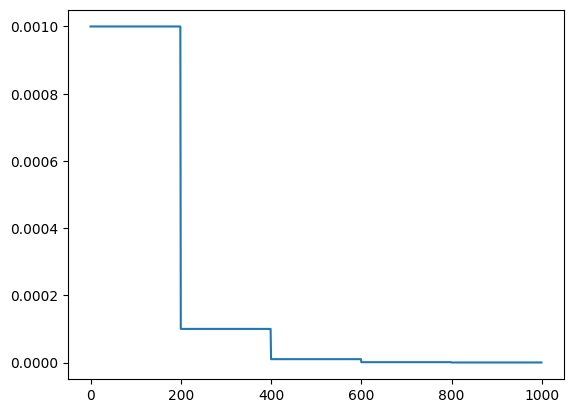

In [30]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

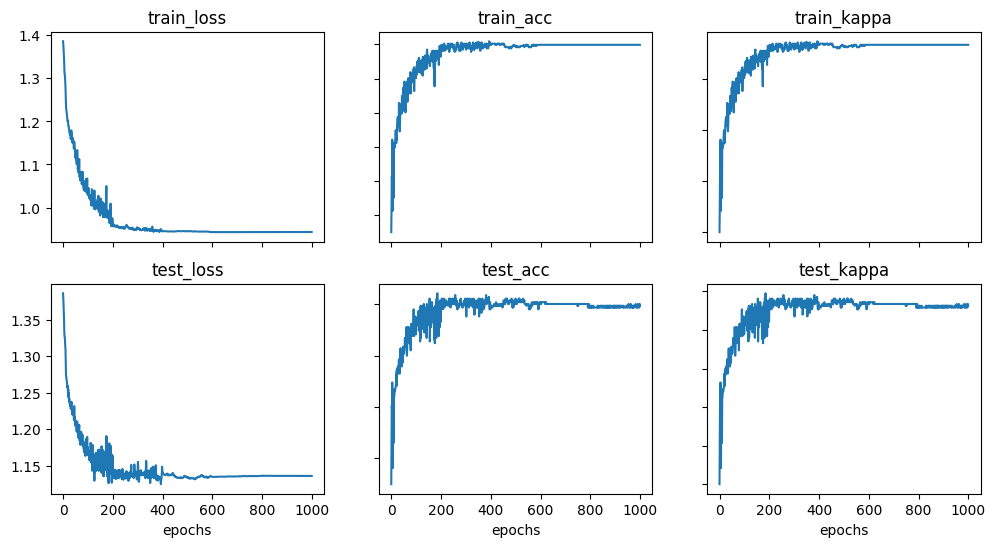

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

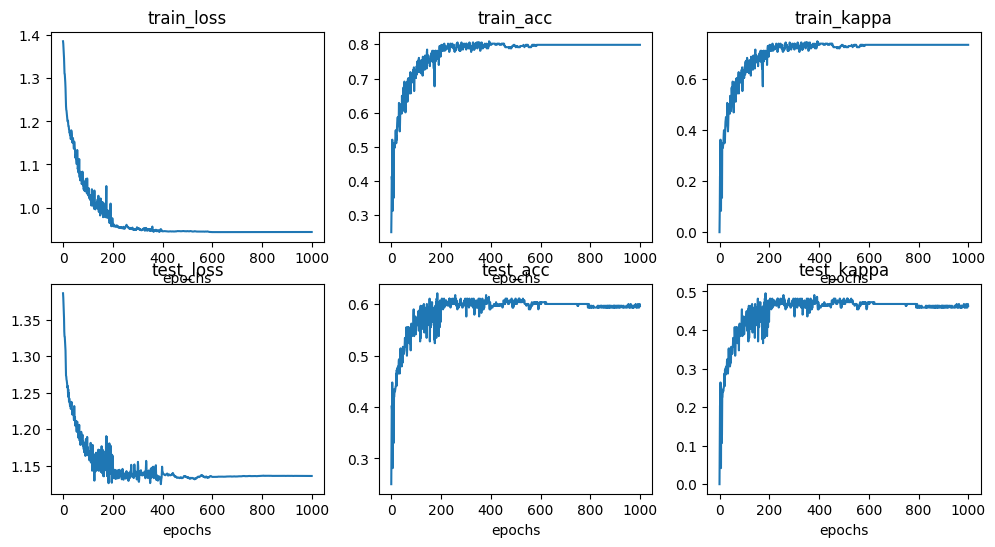

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()